In [1]:
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import confusion_matrix, classification_report


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Using device: cuda
GPU name: NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

full_train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

val_ratio = 0.1
val_size = int(val_ratio * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)} | Val size: {len(val_dataset)} | Test size: {len(test_dataset)}")

batch_size = 64
val_batch_size = 1000
test_batch_size = 1000

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=val_batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=test_batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 6.02MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 249kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.68MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.25MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Train size: 54000 | Val size: 6000 | Test size: 10000


In [4]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(SimpleNN())


SimpleNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [5]:
def train_model(device, num_epochs=5, lr=0.001, verbose=True):
    model = SimpleNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        if verbose:
            print(
                f"Epoch {epoch+1}/{num_epochs} "
                f"- Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}"
            )

    return model, train_loss_history, val_loss_history


In [6]:
num_epochs = 5
learning_rate = 0.001

model, train_loss_history, val_loss_history = train_model(
    device=device,
    num_epochs=num_epochs,
    lr=learning_rate,
    verbose=True
)


Epoch 1/5 - Train Loss: 0.2391 | Val Loss: 0.1256
Epoch 2/5 - Train Loss: 0.0975 | Val Loss: 0.1040
Epoch 3/5 - Train Loss: 0.0651 | Val Loss: 0.0853
Epoch 4/5 - Train Loss: 0.0490 | Val Loss: 0.0867
Epoch 5/5 - Train Loss: 0.0416 | Val Loss: 0.0892


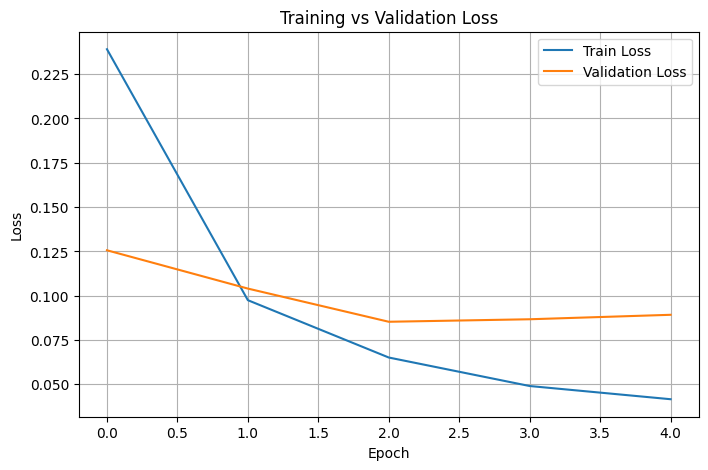

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
criterion = nn.CrossEntropyLoss()

model.eval()
test_loss = 0.0
correct = 0
total = 0

all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100.0 * correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.0864
Test Accuracy: 97.57%


In [9]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.9769    0.9908    0.9838       980
           1     0.9920    0.9894    0.9907      1135
           2     0.9777    0.9787    0.9782      1032
           3     0.9792    0.9772    0.9782      1010
           4     0.9853    0.9582    0.9716       982
           5     0.9953    0.9496    0.9719       892
           6     0.9844    0.9854    0.9849       958
           7     0.9801    0.9601    0.9700      1028
           8     0.9440    0.9856    0.9643       974
           9     0.9454    0.9782    0.9615      1009

    accuracy                         0.9757     10000
   macro avg     0.9760    0.9753    0.9755     10000
weighted avg     0.9761    0.9757    0.9757     10000



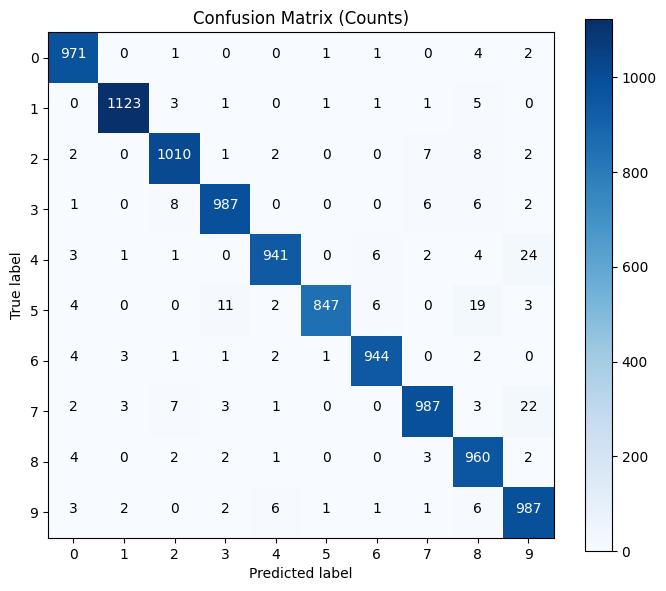

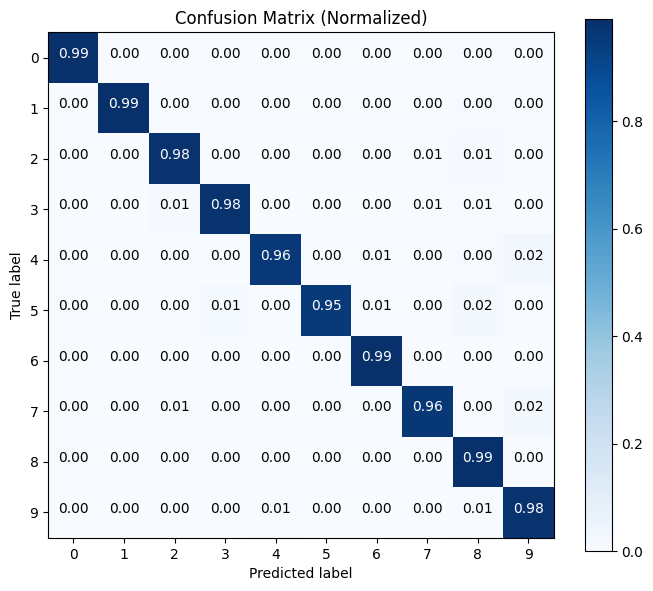

In [10]:
cm = confusion_matrix(all_targets, all_preds)
classes = list(range(10))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()

plot_confusion_matrix(cm, classes=classes, title="Confusion Matrix (Counts)")
plot_confusion_matrix(cm, classes=classes, normalize=True,
                      title="Confusion Matrix (Normalized)")
plt.show()


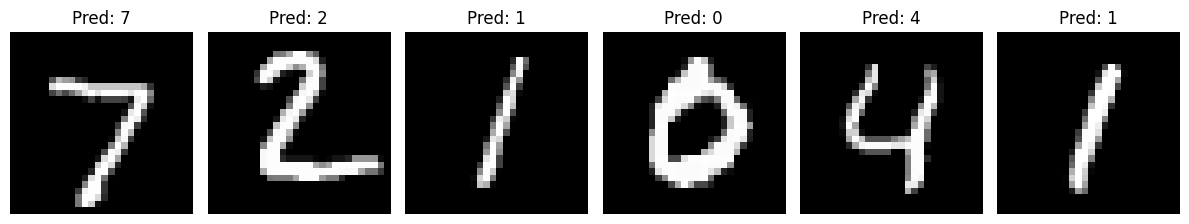

In [12]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data_gpu = example_data.to(device)

model.eval()
with torch.no_grad():
    output = model(example_data_gpu)

plt.figure(figsize=(12, 3))
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(example_data[i][0], cmap="gray")
    pred = output.argmax(dim=1)[i].item()
    plt.title(f"Pred: {pred}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
def benchmark_training(device_str, num_epochs=1):
    dev = torch.device(device_str)
    start = time.time()
    _model, _, _ = train_model(device=dev, num_epochs=num_epochs, lr=learning_rate, verbose=False)
    end = time.time()
    return end - start

devices_to_test = ["cpu"]
if torch.cuda.is_available():
    devices_to_test.append("cuda")

benchmark_results = []

print("Running benchmark (1 epoch)...")
for dev_str in devices_to_test:
    duration = benchmark_training(dev_str, num_epochs=1)
    benchmark_results.append((dev_str, duration))
    print(f"Device: {dev_str} | Time for 1 epoch: {duration:.2f} seconds")


Running benchmark (1 epoch)...
Device: cpu | Time for 1 epoch: 37.64 seconds
Device: cuda | Time for 1 epoch: 26.24 seconds


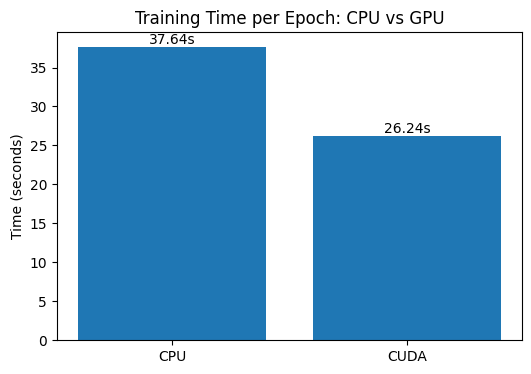

In [14]:
names = [d[0].upper() for d in benchmark_results]
times = [d[1] for d in benchmark_results]

plt.figure(figsize=(6, 4))
bars = plt.bar(names, times)
plt.title("Training Time per Epoch: CPU vs GPU")
plt.ylabel("Time (seconds)")
for bar, t in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f"{t:.2f}s", ha='center', va='bottom')
plt.show()
